In [128]:
import pandas as pd
from IPython.display import Image #type: ignore
from Utils import plot_ts

In [129]:
display(Image(url="Data/Tech_challenge_2.png", width=800, height=500))

- Carregar base

In [130]:
df = pd.read_csv('Data/Dados Históricos - Ibovespa.csv')
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,09.03.2023,105.071,106.540,106.724,105.053,"19,17M","-1,38%"
1,08.03.2023,106.540,104.228,106.721,104.228,"15,90M","2,22%"
2,07.03.2023,104.228,104.700,105.179,103.480,"12,58M","-0,45%"
3,06.03.2023,104.700,103.865,105.171,103.170,"14,28M","0,80%"
4,03.03.2023,103.866,103.326,104.440,103.323,"13,10M","0,52%"


- Tratar valores

In [131]:
df.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [132]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4999 non-null   object 
 1   Último    4999 non-null   float64
 2   Abertura  4999 non-null   float64
 3   Máxima    4999 non-null   float64
 4   Mínima    4999 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      4999 non-null   object 
dtypes: float64(4), object(3)
memory usage: 312.4+ KB


In [133]:
def convert_volume(volume_str):
    volume_str = volume_str.replace(',', '.')
    if 'M' in volume_str:
        return int(float(volume_str.replace('M', '')) * 1000000)
    elif 'K' in volume_str:
        return int(float(volume_str.replace('K', '')) * 1000)
    else:
        return int(volume_str)

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float)
df.Data = pd.to_datetime(df.Data, format='%d.%m.%Y').dt.strftime('%Y-%m-%d')
df.sort_values(by='Data', inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2003-01-02,11.603,11.291,11.603,11.291,195130000,2.97
1,2003-01-03,11.600,11.632,11.798,11.600,197050000,-0.02
2,2003-01-06,12.020,11.636,12.032,11.633,398400000,3.62
3,2003-01-07,11.876,12.010,12.018,11.842,387980000,-1.19
4,2003-01-08,11.786,11.875,11.928,11.757,217190000,-0.76


In [134]:
print("Data mais antiga:", df['Data'].min())
print("Data mais recente:", df['Data'].max())

Data mais antiga: 2003-01-02
Data mais recente: 2023-03-09


In [135]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4999 entries, 0 to 4998
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4999 non-null   object 
 1   Último    4999 non-null   float64
 2   Abertura  4999 non-null   float64
 3   Máxima    4999 non-null   float64
 4   Mínima    4999 non-null   float64
 5   Vol.      4999 non-null   int64  
 6   Var%      4999 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 273.5+ KB


- Ajustar campo **Data** e **index**

In [136]:
df.set_index(df.Data, inplace=True)
df.drop('Data', inplace=True, axis=1)

In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4999 entries, 2003-01-02 to 2023-03-09
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    4999 non-null   float64
 1   Abertura  4999 non-null   float64
 2   Máxima    4999 non-null   float64
 3   Mínima    4999 non-null   float64
 4   Vol.      4999 non-null   int64  
 5   Var%      4999 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 273.4+ KB


- análise

In [138]:
# df.rename(columns={'Data': 'data', 'Último': 'ultimo', 'Abertura': 'abertura', 'Máxima': 'maxima', 'Mínima': 'minima', 'Vol.': 'volume', 'Var%': 'variacao'}, inplace=True)

In [139]:
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2003-01-02,11.603,11.291,11.603,11.291,195130000,2.97
2003-01-03,11.600,11.632,11.798,11.600,197050000,-0.02
2003-01-06,12.020,11.636,12.032,11.633,398400000,3.62
2003-01-07,11.876,12.010,12.018,11.842,387980000,-1.19
2003-01-08,11.786,11.875,11.928,11.757,217190000,-0.76


In [140]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

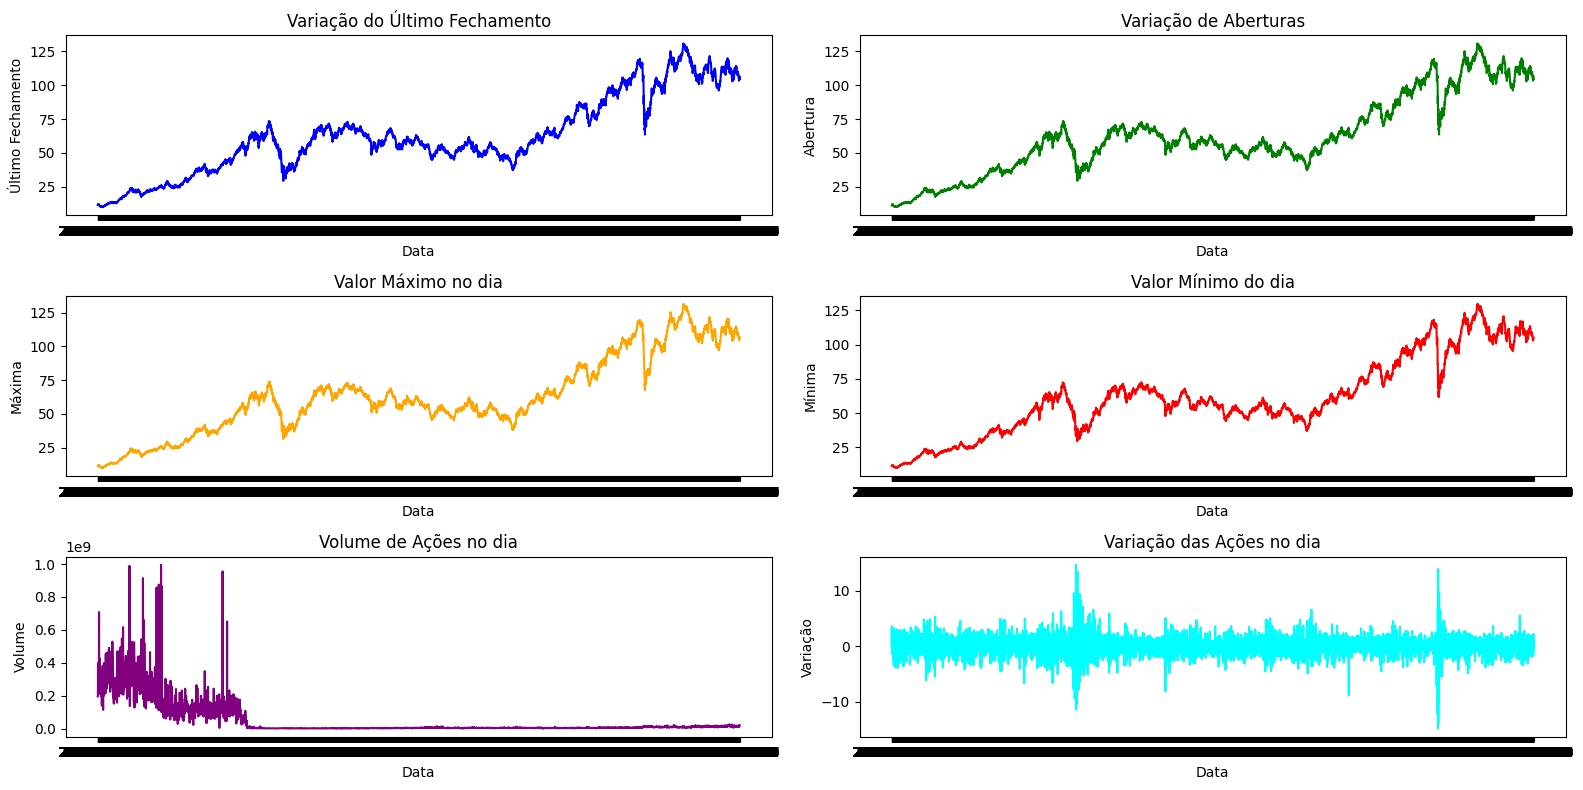

In [110]:
plot_ts(df)

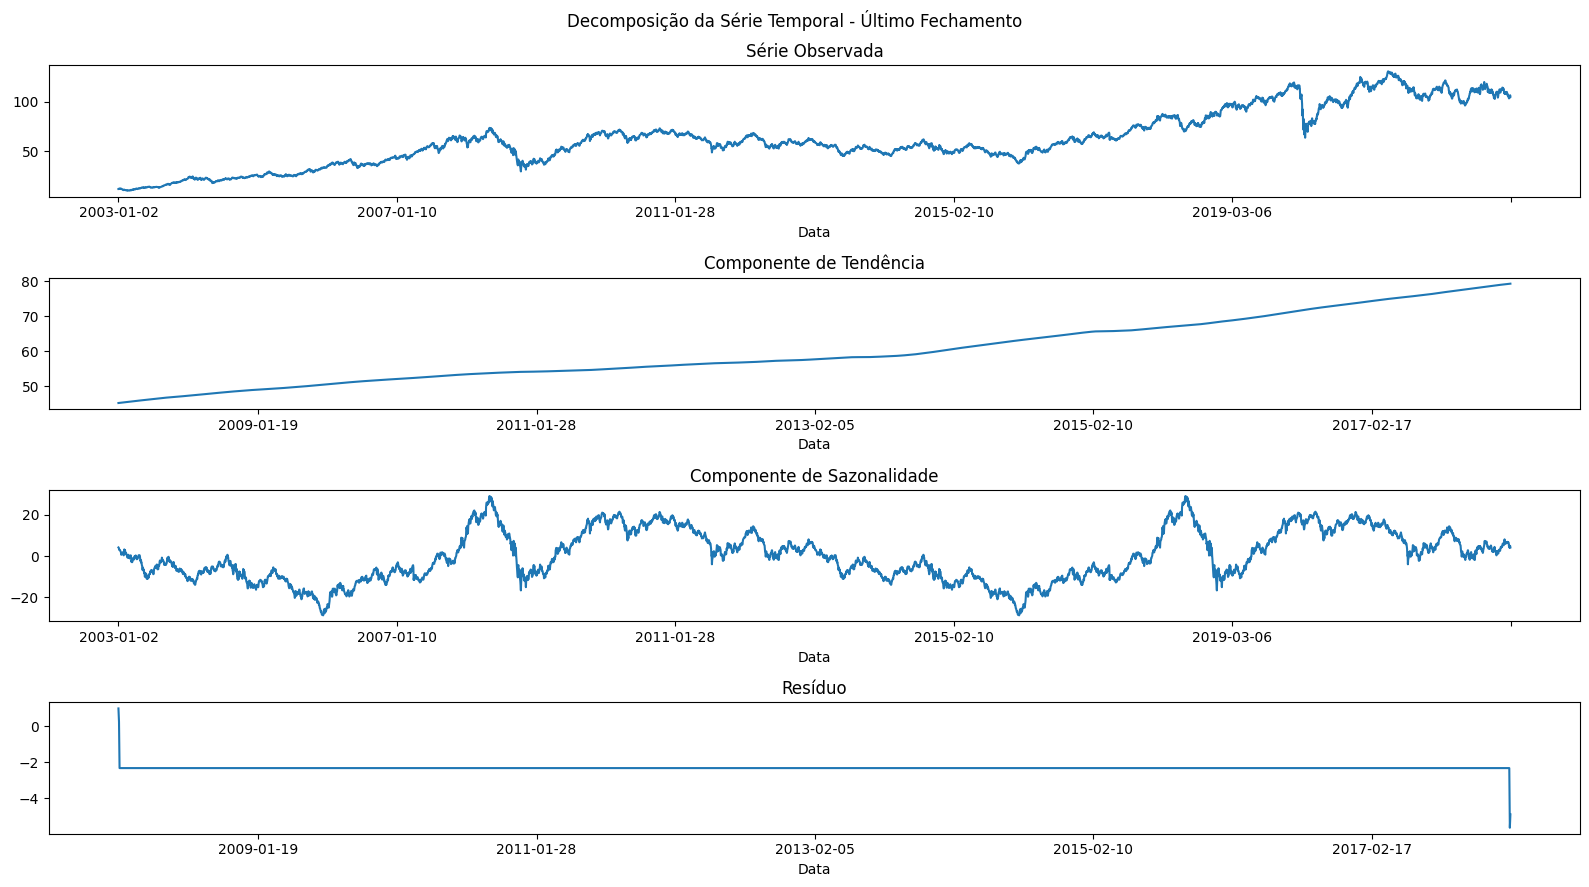

In [173]:
resultados = seasonal_decompose(df['Último'], period=2499)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Último Fechamento', fontsize=12)
plt.tight_layout()
plt.show()

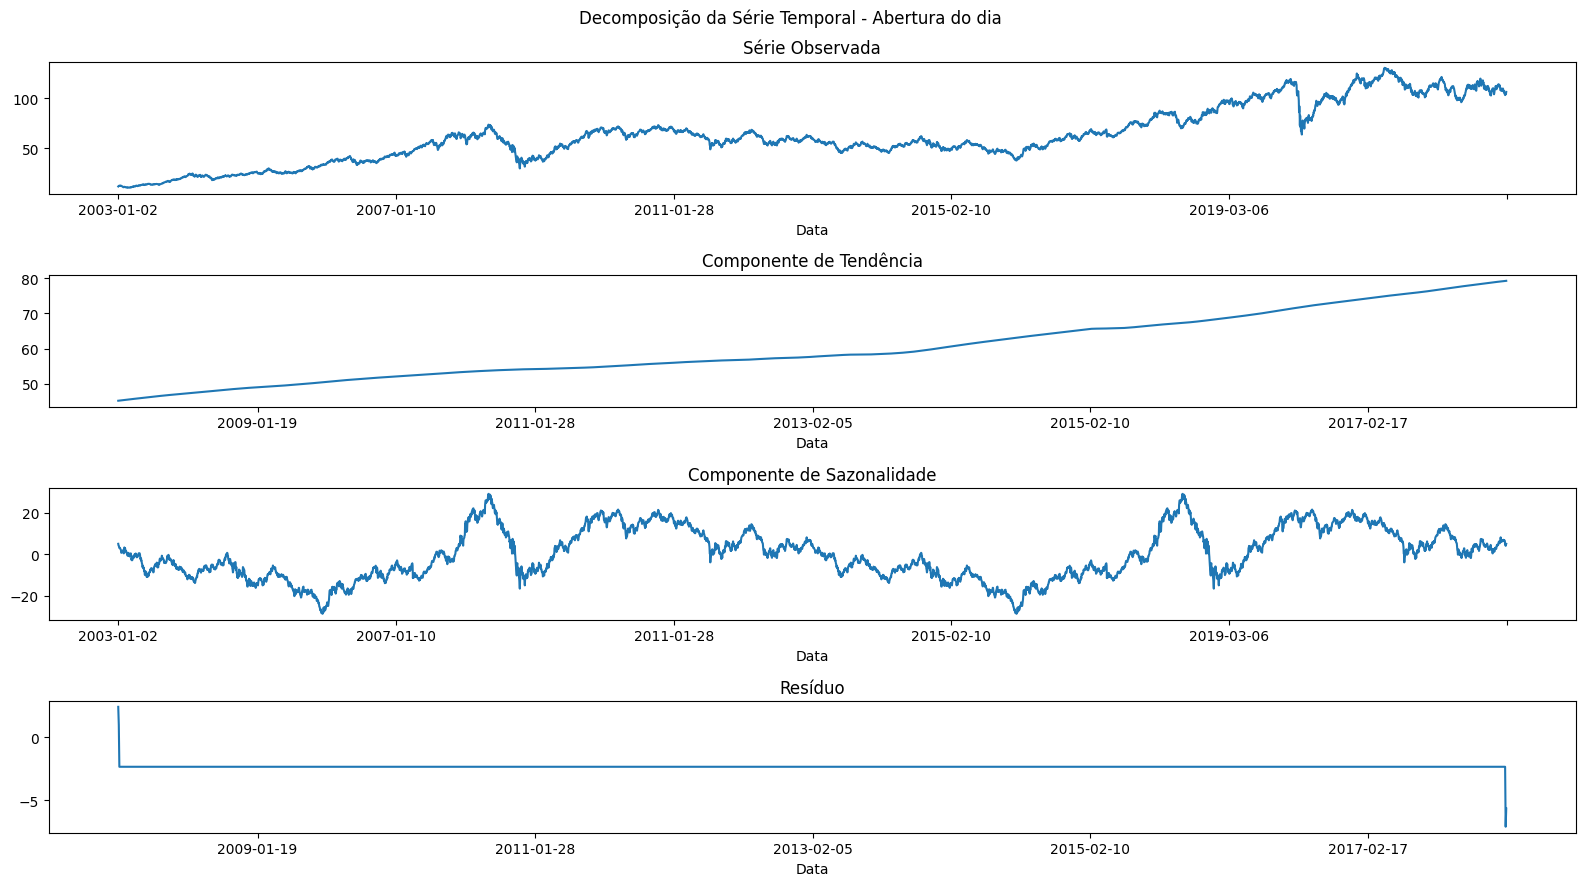

In [174]:
resultados = seasonal_decompose(df['Abertura'], period=2499)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Abertura do dia', fontsize=12)
plt.tight_layout()
plt.show()

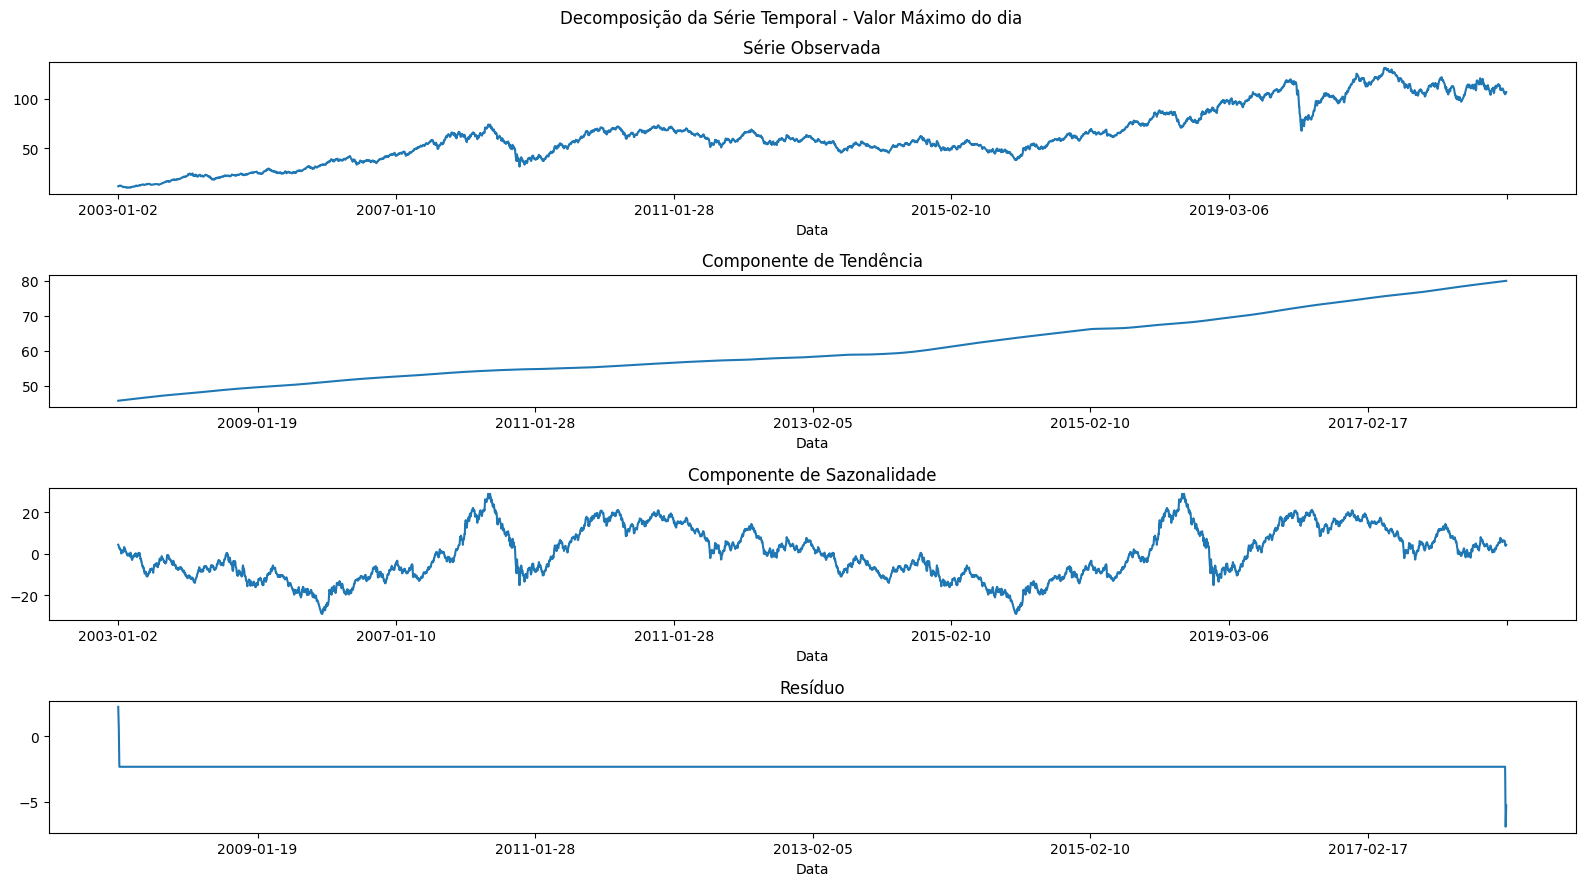

In [175]:
resultados = seasonal_decompose(df['Máxima'], period=2499)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Valor Máximo do dia', fontsize=12)
plt.tight_layout()
plt.show()

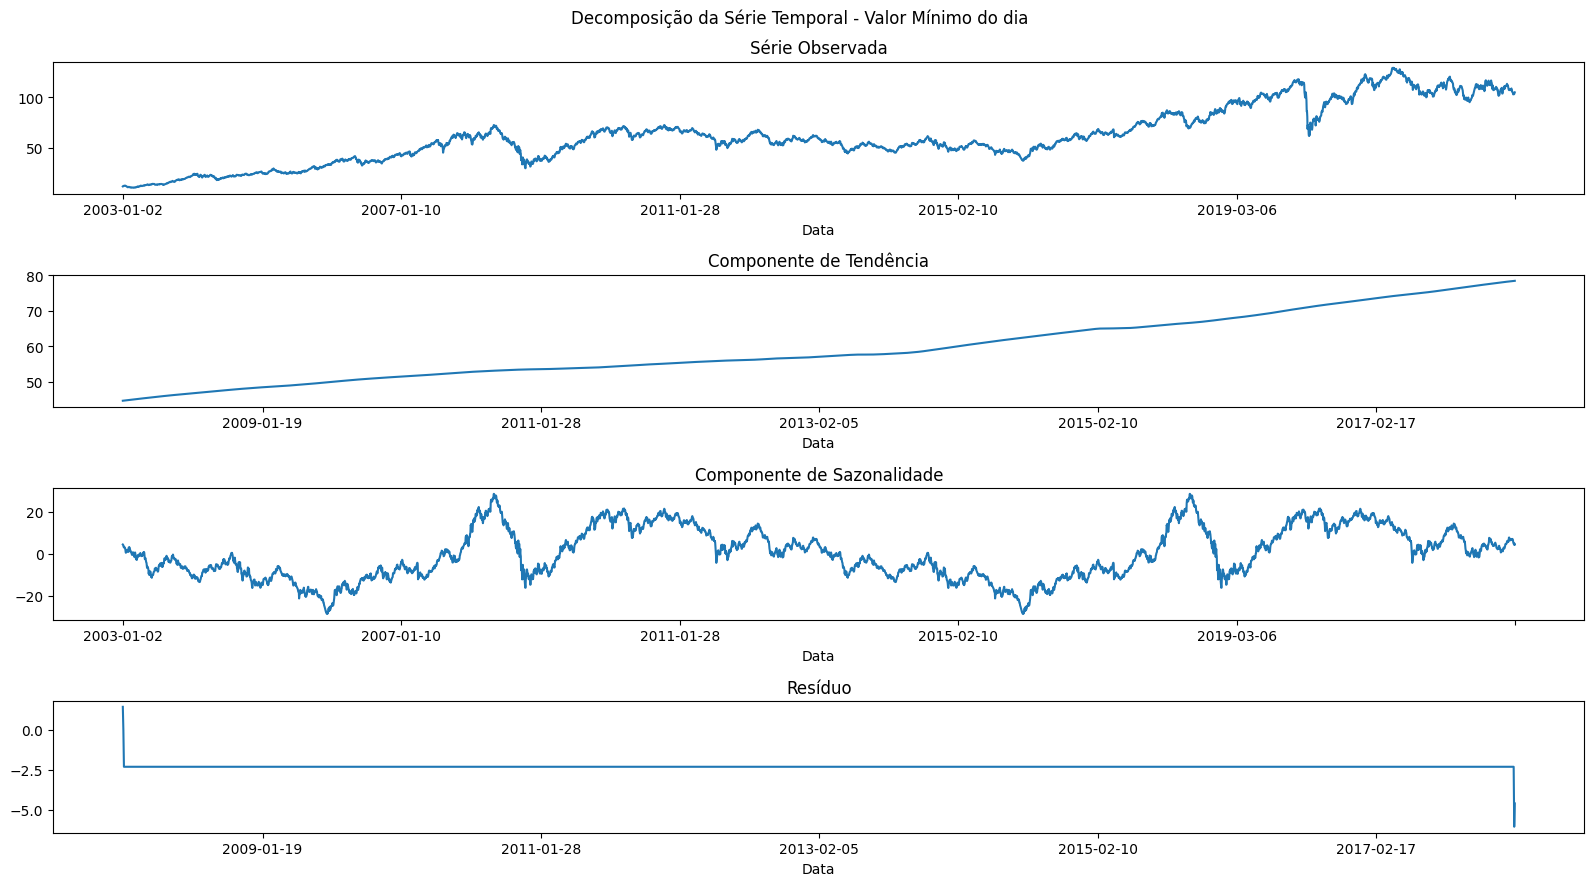

In [176]:
resultados = seasonal_decompose(df['Mínima'], period=2499)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Valor Mínimo do dia', fontsize=12)
plt.tight_layout()
plt.show()

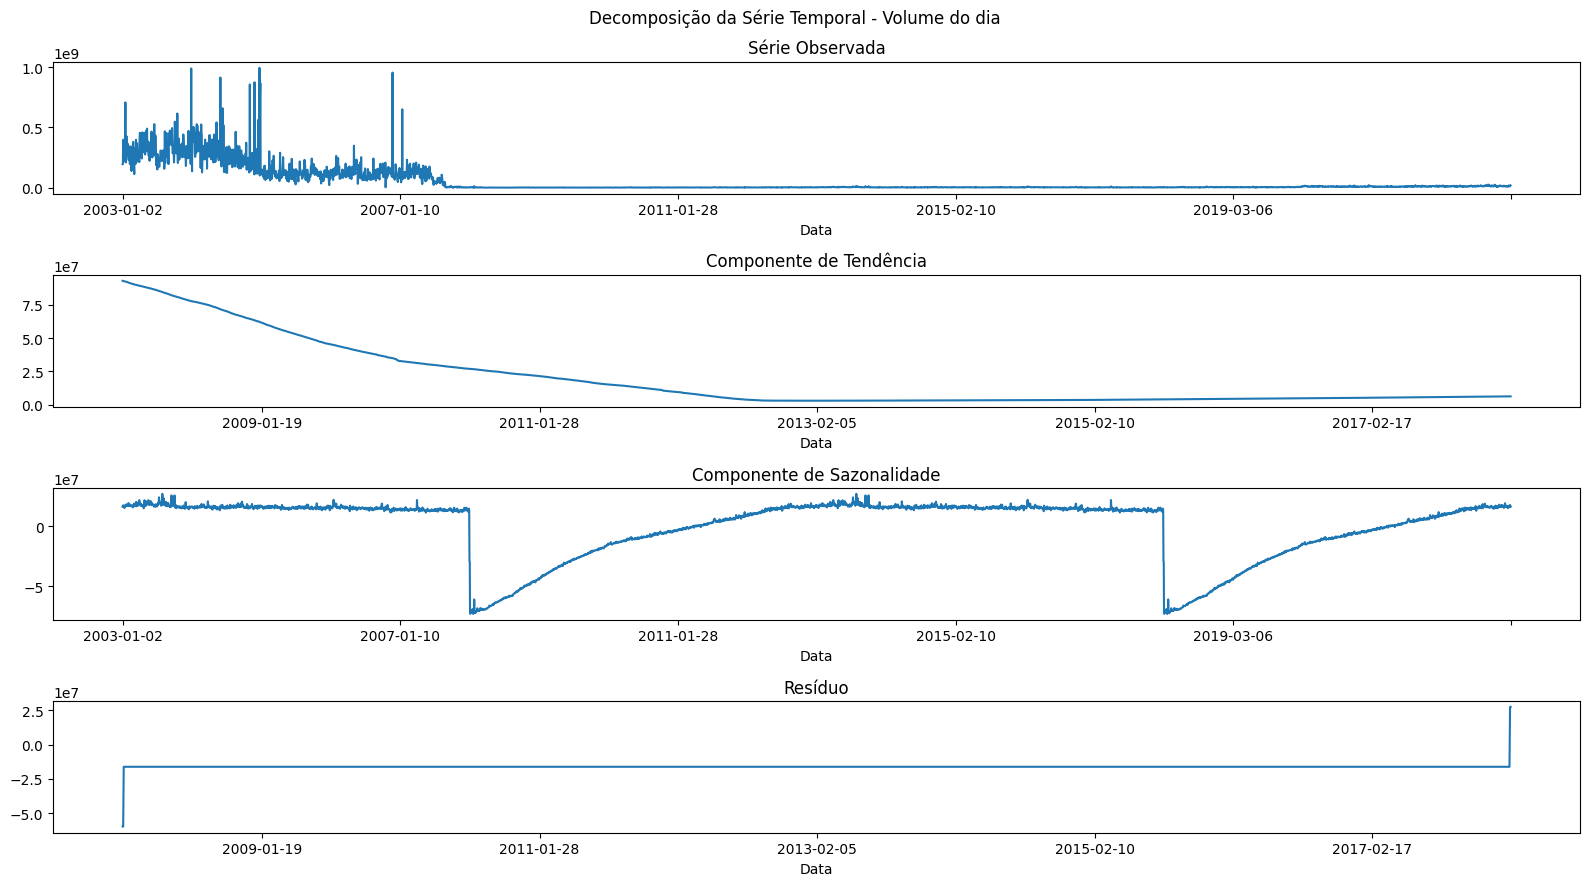

In [177]:
resultados = seasonal_decompose(df['Vol.'], period=2499)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Volume do dia', fontsize=12)
plt.tight_layout()
plt.show()

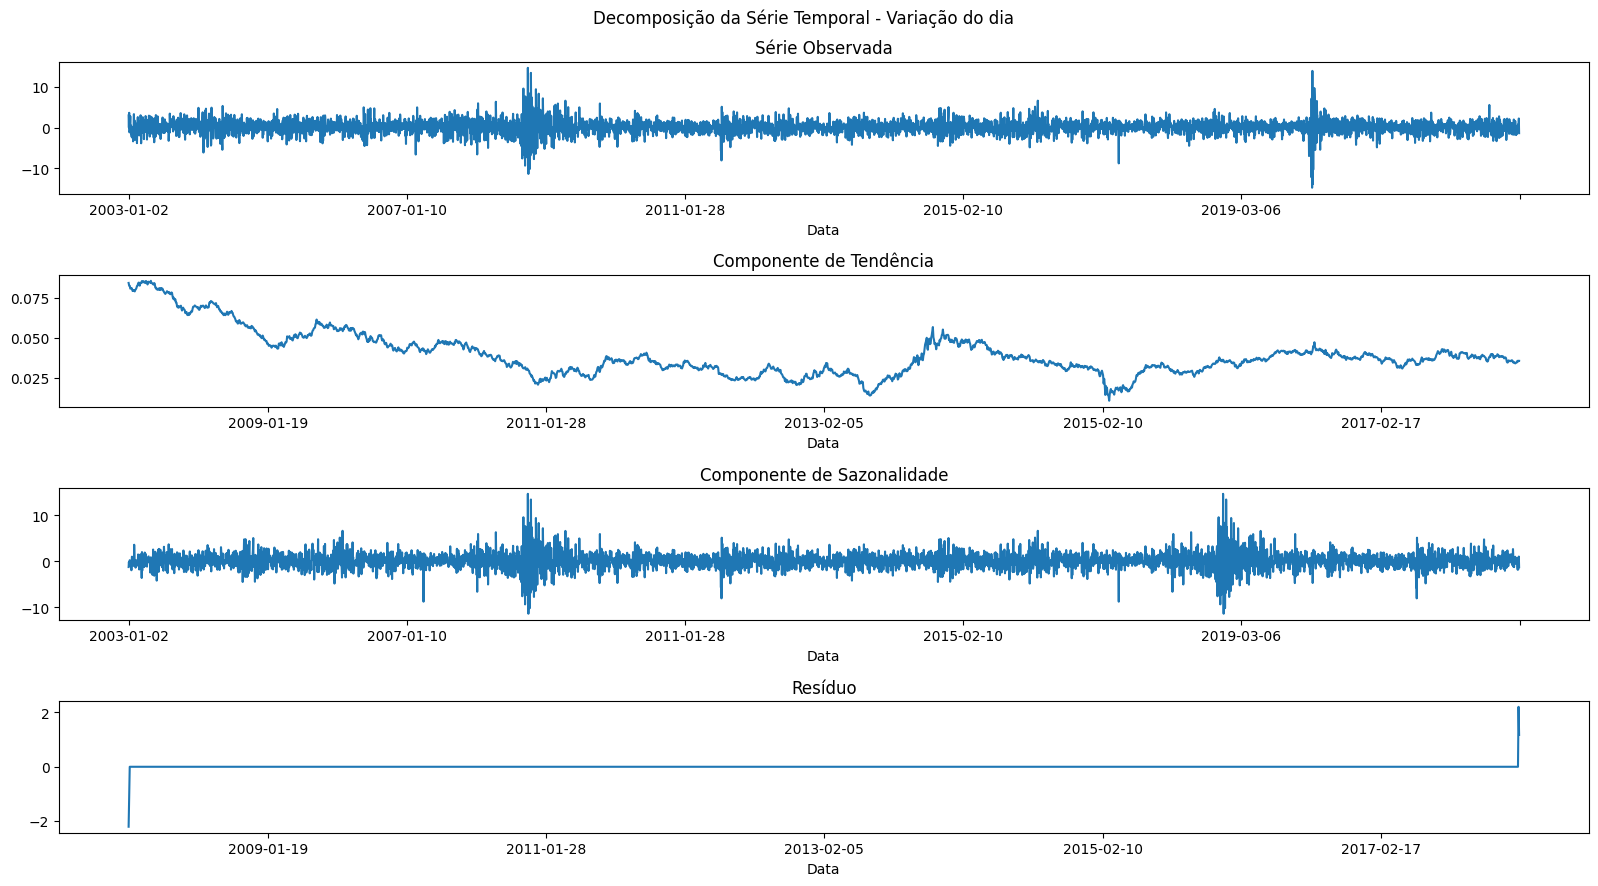

In [178]:
resultados = seasonal_decompose(df['Var%'], period=2499)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 9))
resultados.observed.plot(ax=ax1)
ax1.set_title('Série Observada')
resultados.trend.plot(ax=ax2)
ax2.set_title('Componente de Tendência')
resultados.seasonal.plot(ax=ax3)
ax3.set_title('Componente de Sazonalidade')
resultados.resid.plot(ax=ax4)
ax4.set_title('Resíduo')
plt.suptitle('Decomposição da Série Temporal - Variação do dia', fontsize=12)
plt.tight_layout()
plt.show()

#### Teste Augmented Dickey Fuller

> Hipótese
---
- H0 - Hipótese Nula (não é estacionária) não é estacionaria
- H1 - Hipótese Alternativa (rejeição da hipótese nula) é estacionaria

In [179]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Último'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.582468902453259
P-Value: 0.4923936999320565
Valores criticos:
	1%: -3.431661944885779
	5%: -2.8621197374408225
	10%: -2.5670785949998973


> Resultado
---
- p-value 49% e teste estatístico maior que os valores criticos: Não é estacionaria

In [180]:
result = adfuller(df['Abertura'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.5501918275983444
P-Value: 0.5085523743201463
Valores criticos:
	1%: -3.431661944885779
	5%: -2.8621197374408225
	10%: -2.5670785949998973


> Resultado
---
- p-value 50% e teste estatístico maior que os valores criticos: Não é estacionaria

In [181]:
result = adfuller(df['Máxima'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.4916190799798554
P-Value: 0.5376531111835645
Valores criticos:
	1%: -3.4316614186797896
	5%: -2.8621195049660733
	10%: -2.567078471244475


> Resultado
---
- p-value 53% e teste estatístico maior que os valores criticos: Não é estacionaria

In [182]:
result = adfuller(df['Mínima'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -1.548002712983739
P-Value: 0.5096457127083619
Valores criticos:
	1%: -3.4316614186797896
	5%: -2.8621195049660733
	10%: -2.567078471244475


> Resultado
---
- p-value 50% e teste estatístico maior que os valores criticos: Não é estacionaria

In [183]:
result = adfuller(df['Vol.'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -2.7568043244385723
P-Value: 0.06471377739716942
Valores criticos:
	1%: -3.4316669649844727
	5%: -2.8621219552891963
	10%: -2.5670797756478825


> Resultado
---
- p-value 6% e teste estatístico maior que os valor critico de 5%: Não é estacionaria

In [184]:
result = adfuller(df['Var%'].values)
print('Teste ADf')
print(f'Teste estatistico: {result[0]}')
print(f'P-Value: {result[1]}')
print(f'Valores criticos:')

for key, value in result[4].items(): #type: ignore
    print(f'\t{key}: {value}')

Teste ADf
Teste estatistico: -31.11745683270484
P-Value: 0.0
Valores criticos:
	1%: -3.431660367533127
	5%: -2.862119040575461
	10%: -2.5670782240311683


> Resultado
---
p-value 0.0% e teste estatístico menor que os valores criticos: É estacionaria